# Data exploration

source = https://www.kaggle.com/datasets/aniket0712/nypd-complaint-data-historic?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, time

In [2]:
data_folder = '../data/'
df = pd.read_csv(data_folder+'NYPD_Complaint_Data_Historic.csv', dtype={'CMPLNT_NUM': str})

In [3]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,39468181,02/20/2008,07:00:00,02/23/2008,08:00:00,88.0,02/23/2008,107,BURGLARY,221.0,...,(null),NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,(null),25-44,WHITE,F
1,50539499,08/21/2008,22:00:00,08/21/2008,23:00:00,19.0,08/22/2008,109,GRAND LARCENY,438.0,...,(null),NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,(null),45-64,WHITE HISPANIC,F
2,45223390,04/03/2008,03:35:00,04/03/2008,03:50:00,77.0,04/03/2008,106,FELONY ASSAULT,109.0,...,(null),NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
3,50594658,08/19/2008,09:00:00,NaN,(null),32.0,08/27/2008,341,PETIT LARCENY,349.0,...,(null),NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,(null),(null),UNKNOWN,M
4,44451016,03/10/2008,22:00:00,03/10/2008,22:10:00,67.0,03/11/2008,105,ROBBERY,397.0,...,M,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,M


In [4]:
print(f"We have {df.shape[0]:,} datapoints with {df.shape[1]} features")

We have 8,914,838 datapoints with 35 features


# NYPD Complaints 

| Column Name      | Description |
|-----------------|-------------|
| **CMPLNT_NUM**  | Unique identifier for each complaint |
| **CMPLNT_FR_DT** | Date when the incident started |
| **CMPLNT_FR_TM** | Time when the incident started |
| **CMPLNT_TO_DT** | Date when the incident ended (if applicable) |
| **CMPLNT_TO_TM** | Time when the incident ended (if applicable) |
| **ADDR_PCT_CD**  | Precinct where the complaint was reported |
| **RPT_DT**       | Date when the complaint was officially recorded |
| **KY_CD**        | Numeric offense code |
| **OFNS_DESC**    | Description of the offense |
| **PD_CD**        | Police department-specific offense code |
| **PD_DESC**      | Description of the police department offense classification |
| **CRM_ATPT_CPTD_CD** | Whether the crime was **completed** or an **attempt** |
| **LAW_CAT_CD**   | Severity of the offense (Felony, Misdemeanor, Violation) |
| **BORO_NM**      | Borough where the crime occurred (Manhattan, Brooklyn, etc.) |
| **LOC_OF_OCCUR_DESC** | Location type (e.g., street, residence, transit) |
| **PREM_TYP_DESC** | Type of premises where the incident occurred (e.g., apartment, store) |
| **JURIS_DESC**   | Jurisdiction responsible for the case |
| **JURISDICTION_CODE** | Numeric jurisdiction code |
| **PARKS_NM**     | Name of the park (if applicable) |
| **HADEVELOPT**   | NYC Housing Authority development name |
| **HOUSING_PSA**  | Housing Police Service Area |
| **X_COORD_CD**   | X-coordinate (NYC coordinate system) |
| **Y_COORD_CD**   | Y-coordinate (NYC coordinate system) |
| **SUSP_AGE_GROUP** | Age group of the suspect |
| **SUSP_RACE**    | Race of the suspect |
| **SUSP_SEX**     | Gender of the suspect |
| **TRANSIT_DISTRICT** | Transit district (if applicable) |
| **Latitude**     | Latitude of the crime location |
| **Longitude**    | Longitude of the crime location |
| **Lat_Lon**      | Combined Latitude & Longitude |
| **PATROL_BORO**  | Patrol Borough where the incident occurred |
| **STATION_NAME** | Subway station name (if applicable) |
| **VIC_AGE_GROUP** | Age group of the victim |
| **VIC_RACE**     | Race of the victim |
| **VIC_SEX**      | Gender of the victim |



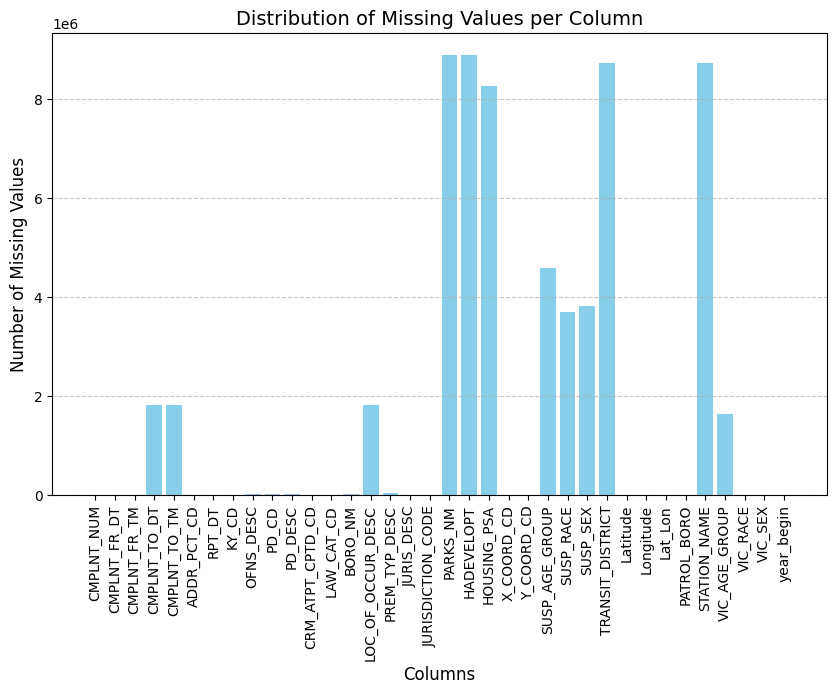

In [123]:
df.replace("(null)", np.nan, inplace=True)
missing_counts = df.isna().sum()

plt.figure(figsize=(10, 6))
plt.bar(missing_counts.index, missing_counts.values, color='skyblue')

plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.title("Distribution of Missing Values per Column", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Missing values seem to correspond to when the feature is not applicable, not bad data!

In [6]:
unique_precinct = df['ADDR_PCT_CD'].unique()
print(unique_precinct)

[ 88.  19.  77.  32.  67.  34.  78.  23.  61.  83.  66.  62.  20.  44.
  17.  70.  73.  63.  46.  40.  28.  79.  26.  18.  24.  71.  43.  33.
  90. 114.  69.  30. 108.  81.  50.  94.  25.  60.  42.   9.  13. 104.
  72.  22.  52.   7. 115.  49.  47. 100.  41. 112.  75.  48. 110. 102.
 106. 109.  45. 107. 103. 113. 105. 111. 101.   1. 120.  10. 122.  68.
   6. 123.  nan  76.  84. 121.   5.  14.]


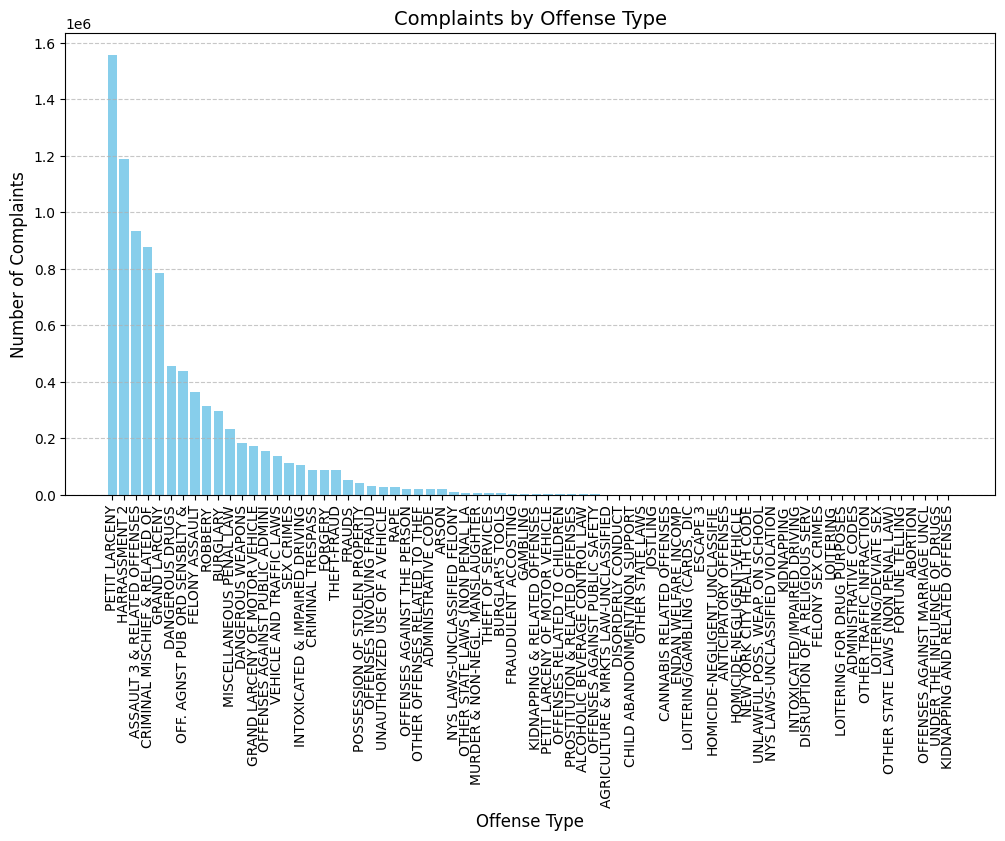

In [8]:
offense_counts = df['OFNS_DESC'].value_counts()

# Plot histogram (bar chart)
plt.figure(figsize=(12, 6))
plt.bar(offense_counts.index, offense_counts.values, color='skyblue')

# Formatting
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.ylabel("Number of Complaints", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Complaints by Offense Type", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


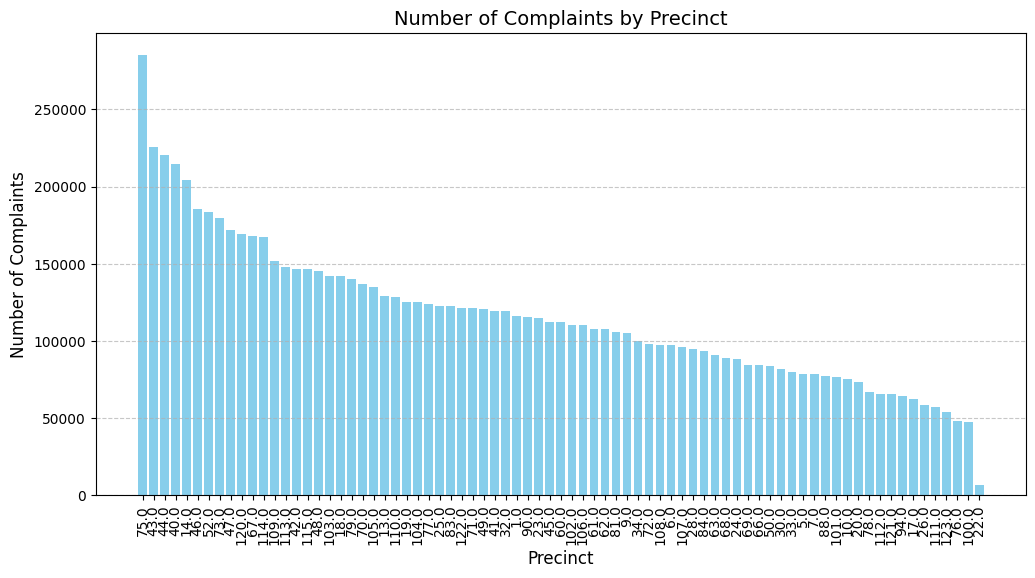

In [9]:

precinct_counts = df['ADDR_PCT_CD'].value_counts()

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(precinct_counts.index.astype(str), precinct_counts.values, color='skyblue')

# Formatting
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.ylabel("Number of Complaints", fontsize=12)
plt.xlabel("Precinct", fontsize=12)
plt.title("Number of Complaints by Precinct", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [76]:
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')
df['CMPLNT_TO_DT'] = pd.to_datetime(df['CMPLNT_TO_DT'], format='%m/%d/%Y', errors='coerce')
df['RPT_DT'] = pd.to_datetime(df['RPT_DT'], format='%m/%d/%Y', errors='coerce')


In [11]:
df["case_duration"] = df.apply(lambda row: np.inf if pd.isna(row["CMPLNT_TO_DT"]) 
                               else (row['CMPLNT_TO_DT'] - row['CMPLNT_FR_DT']).days, axis=1)

In [12]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,case_duration
0,39468181,2008-02-20,07:00:00,2008-02-23,08:00:00,88.0,2008-02-23,107,BURGLARY,221.0,...,NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F,3.0
1,50539499,2008-08-21,22:00:00,2008-08-21,23:00:00,19.0,2008-08-22,109,GRAND LARCENY,438.0,...,NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,NaN,45-64,WHITE HISPANIC,F,0.0
2,45223390,2008-04-03,03:35:00,2008-04-03,03:50:00,77.0,2008-04-03,106,FELONY ASSAULT,109.0,...,NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,NaN,25-44,BLACK,F,0.0
3,50594658,2008-08-19,09:00:00,NaT,NaN,32.0,2008-08-27,341,PETIT LARCENY,349.0,...,NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,M,inf
4,44451016,2008-03-10,22:00:00,2008-03-10,22:10:00,67.0,2008-03-11,105,ROBBERY,397.0,...,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,NaN,25-44,BLACK,M,0.0


# Women centered analysis:

## Percentage of female victims:

In [13]:
df.isna().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT             828
CMPLNT_FR_TM              48
CMPLNT_TO_DT         1818964
CMPLNT_TO_TM         1813518
ADDR_PCT_CD              771
RPT_DT                     0
KY_CD                      0
OFNS_DESC              18886
PD_CD                   7593
PD_DESC                 7593
CRM_ATPT_CPTD_CD         168
LAW_CAT_CD                 0
BORO_NM                 7884
LOC_OF_OCCUR_DESC    1821966
PREM_TYP_DESC          39001
JURIS_DESC                 0
JURISDICTION_CODE          0
PARKS_NM             8877278
HADEVELOPT           8883190
HOUSING_PSA          8244451
X_COORD_CD               466
Y_COORD_CD               466
SUSP_AGE_GROUP       4583671
SUSP_RACE            3687178
SUSP_SEX             3820549
TRANSIT_DISTRICT     8716793
Latitude                 466
Longitude                466
Lat_Lon                  466
PATROL_BORO              587
STATION_NAME         8716793
VIC_AGE_GROUP        1623568
VIC_RACE                 671
VIC_SEX       

In [14]:
# U is for unknown so we replace it with nan
df['VIC_SEX'].replace("U", np.nan, inplace=True)

/var/folders/yc/lz46krrd2mj9d_tjm637grg40000gn/T/ipykernel_52649/831186619.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['VIC_SEX'].replace("U", np.nan, inplace=True)


In [15]:
df['VIC_SEX'].value_counts()

VIC_SEX
F    3485031
M    2970472
E    1292503
D    1160458
L       6062
Name: count, dtype: int64

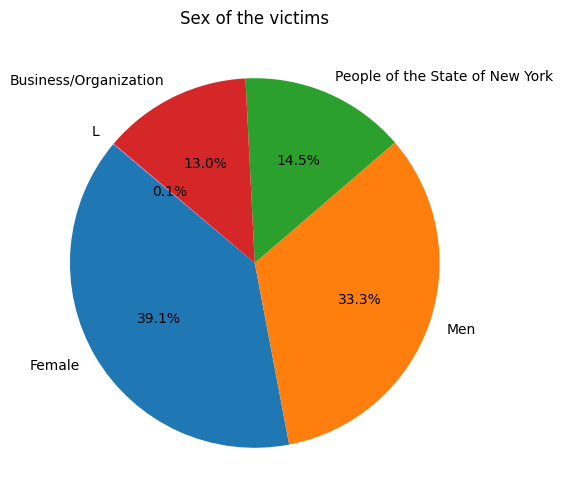

In [16]:
#F=Female
#M=Male
#E=PSNY/People of the State of New York
#D=Business/Organization,


labels= ["Female", "Men", "People of the State of New York", "Business/Organization", "L"]
sizes = df['VIC_SEX'].value_counts()
#sizes["Unknown"] = df["VIC_SEX"].isna().sum()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the victims')
plt.show()

Now taking only when victim is a single person

In [ ]:
df_gender = df.query("(VIC_SEX == 'F')| (VIC_SEX =='M')")

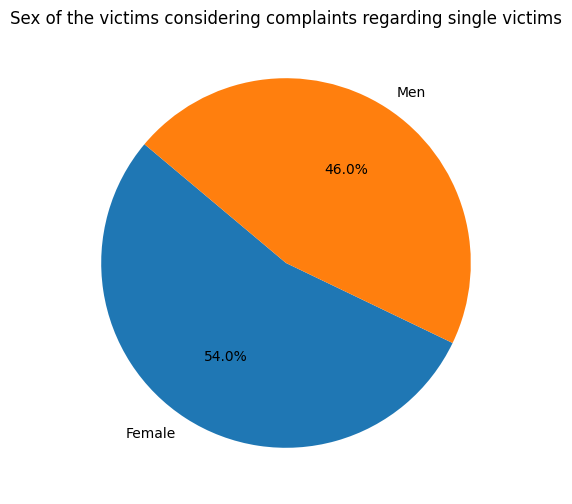

In [38]:
labels= ["Female", "Men"]
sizes = [df_gender['VIC_SEX'].value_counts().get('F', 0),
         df_gender['VIC_SEX'].value_counts().get('M', 0)]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the victims considering complaints regarding single victims')
plt.show()

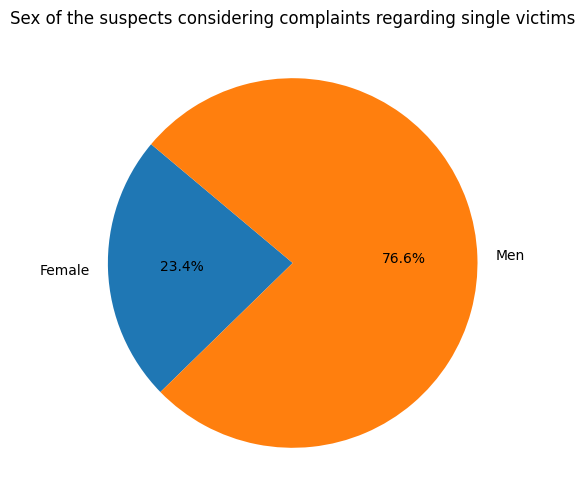

In [36]:
df_gender_susp = df[df['SUSP_SEX'].isin(['F', 'M'])]

labels= ["Female", "Men"]
sizes = [df_gender_susp['SUSP_SEX'].value_counts().get('F', 0),
         df_gender_susp['SUSP_SEX'].value_counts().get('M', 0)]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the suspects considering complaints regarding single victims')
plt.show()

## Types of crimes women and men are victim of:

In [19]:
women_victims = df_gender.query("VIC_SEX == 'F'")
men_victims = df_gender.query("VIC_SEX == 'M'")

In [20]:
women_victims["PD_DESC"].unique

<bound method Series.unique of 0                                     BURGLARY,RESIDENCE,DAY
1          LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UN...
2                                   ASSAULT 2,1,UNCLASSIFIED
8                                       TRESPASS 2, CRIMINAL
9                                 HARASSMENT,SUBD 1,CIVILIAN
                                 ...                        
8914824                              AGGRAVATED HARASSMENT 2
8914832                       LARCENY,PETIT OF LICENSE PLATE
8914834                       FORGERY,ETC.,UNCLASSIFIED-FELO
8914836                                            ASSAULT 3
8914837                             ASSAULT 2,1,UNCLASSIFIED
Name: PD_DESC, Length: 3485031, dtype: object>

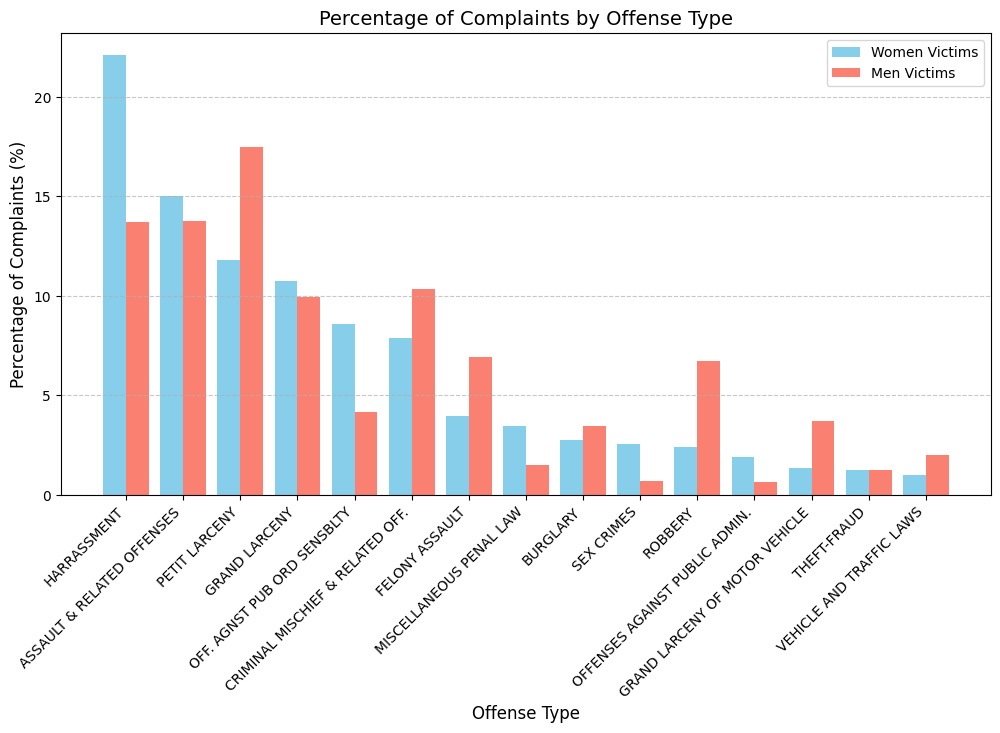

In [68]:
import matplotlib.pyplot as plt

def rename_dict_key(oldkey, newkey, dict):
    dict[newkey] = dict[oldkey]
    del dict[oldkey]

# Get top 15 offenses for women victims in percentage
top_women_offenses = women_victims['OFNS_DESC'].value_counts(normalize=True)[:15] * 100

# Get offense counts for men victims in percentage
men_offense_counts = men_victims['OFNS_DESC'].value_counts(normalize=True) * 100

# Align men’s offenses with the top 15 women’s offenses
men_percentages = men_offense_counts.reindex(top_women_offenses.index).fillna(0)
rename_dict_key('HARRASSMENT 2','HARRASSMENT',top_women_offenses)
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES',top_women_offenses)
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY',top_women_offenses)
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.',top_women_offenses)
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.', top_women_offenses)

rename_dict_key('HARRASSMENT 2','HARRASSMENT',men_percentages)
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES',men_percentages)
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY',men_percentages)
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.',men_percentages)
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.', men_percentages)

# Sort top offenses for women victims
top_women_offenses = top_women_offenses.sort_values(ascending=False)
men_percentages = men_percentages.reindex(top_women_offenses.index).fillna(0)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
x_labels = top_women_offenses.index
x = range(len(x_labels))

plt.bar(x, top_women_offenses.values, width=bar_width, label="Women Victims", color='skyblue', align='center')
plt.bar([i + bar_width for i in x], men_percentages.values, width=bar_width, label="Men Victims", color='salmon', align='center')

plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45, ha="right", fontsize=10)

plt.ylabel("Percentage of Complaints (%)", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Percentage of Complaints by Offense Type", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('men_vs_women_victims.png', bbox_inches='tight')

plt.show()



In [ ]:
top_women_offenses
def rename_dict_key(oldkey, newkey):
    top_women_offenses[newkey] = top_women_offenses[oldkey]
    del top_women_offenses[oldkey]

rename_dict_key('HARRASSMENT 2','HARRASSMENT')
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES')
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY')
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.')
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.')

In [57]:
top_women_offenses.keys()

Index(['PETIT LARCENY', 'GRAND LARCENY', 'OFF. AGNST PUB ORD SENSBLTY &',
       'CRIMINAL MISCHIEF & RELATED OF', 'FELONY ASSAULT',
       'MISCELLANEOUS PENAL LAW', 'BURGLARY', 'SEX CRIMES', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'GRAND LARCENY OF MOTOR VEHICLE',
       'THEFT-FRAUD', 'VEHICLE AND TRAFFIC LAWS', 'HARRASSMENT',
       'ASSAULT & RELATED OFFENSES'],
      dtype='object', name='OFNS_DESC')

## Types of crimes women and men are suspected of:

In [26]:
women_suspect = df_gender.query("SUSP_SEX == 'F'")
men_suspect = df_gender.query("SUSP_SEX == 'M'")

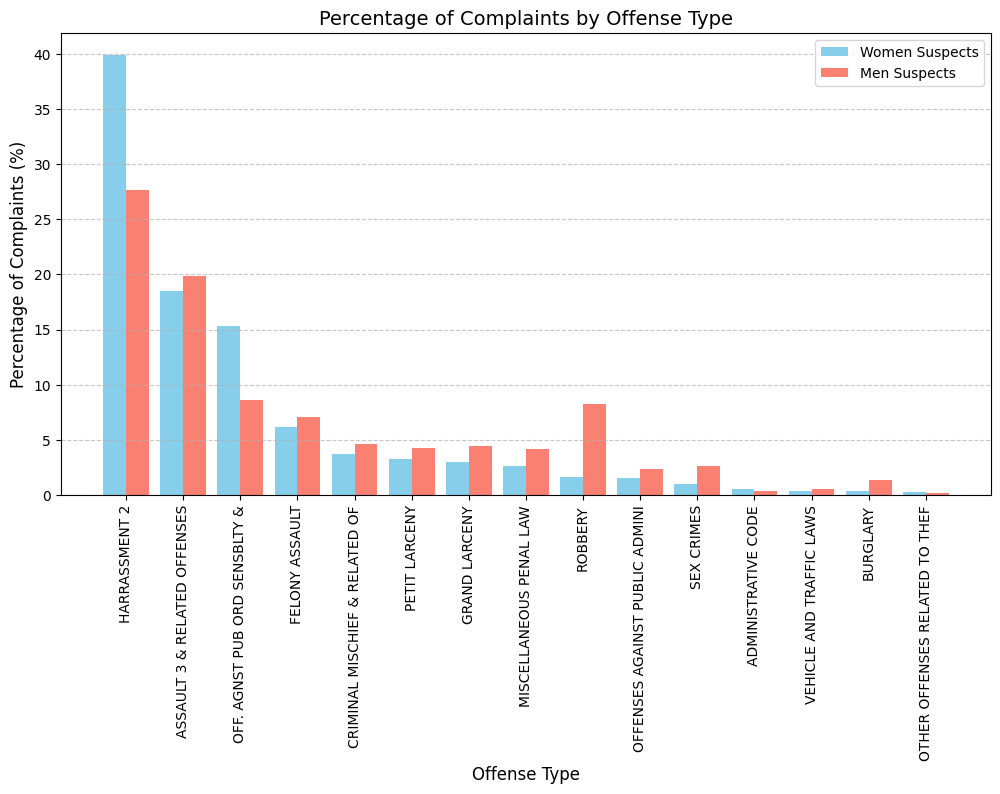

In [28]:
import matplotlib.pyplot as plt

# Get top 15 offenses for women victims in percentage
top_women_offenses = women_suspect['OFNS_DESC'].value_counts(normalize=True)[:15] * 100

# Get offense counts for men victims in percentage
men_offense_counts = men_suspect['OFNS_DESC'].value_counts(normalize=True) * 100

# Align men’s offenses with the top 15 women’s offenses
men_percentages = men_offense_counts.reindex(top_women_offenses.index).fillna(0)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
x_labels = top_women_offenses.index
x = range(len(x_labels))

plt.bar(x, top_women_offenses.values, width=bar_width, label="Women Suspects", color='skyblue', align='center')
plt.bar([i + bar_width for i in x], men_percentages.values, width=bar_width, label="Men Suspects", color='salmon', align='center')

plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.ylabel("Percentage of Complaints (%)", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Percentage of Complaints by Offense Type", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Dangerous hours for men VS women:

{'07': 90568, '22': 157384, '03': 68666, '15': 209274, '19': 189150, '20': 189036, '23': 143145, '21': 170905, '06': 54867, '01': 102630, '11': 152708, '18': 202099, '00': 158818, '14': 185629, '08': 145743, '12': 211924, '05': 48380, '17': 196380, '02': 82676, '13': 167958, '16': 193217, '10': 153762, '09': 151904, '04': 58187}


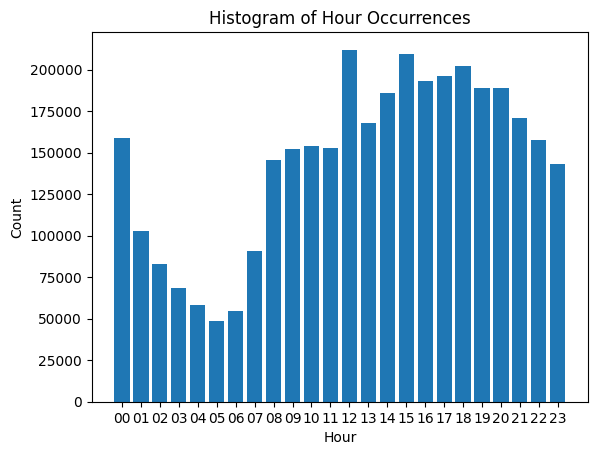

In [74]:
hours=women_victims['CMPLNT_FR_TM'].str[:2]
hours=hours[~(hours=='(n')]
hours_dict=hours.value_counts(sort=False).to_dict()
print(hours_dict)
hours_sorted = dict(sorted(hours_dict.items(), key=lambda x: int(x[0])))

plt.bar(hours_sorted.keys(), hours_sorted.values())
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Histogram of Hour Occurrences")
plt.show()

{'22': 116603, '06': 42149, '19': 129419, '23': 108043, '01': 84824, '11': 102535, '00': 107721, '14': 125555, '12': 125822, '17': 131969, '21': 125143, '05': 43937, '20': 132042, '18': 133891, '15': 141403, '13': 112549, '16': 132695, '07': 58245, '10': 97962, '08': 84632, '04': 58325, '03': 64054, '02': 72738, '09': 89316}


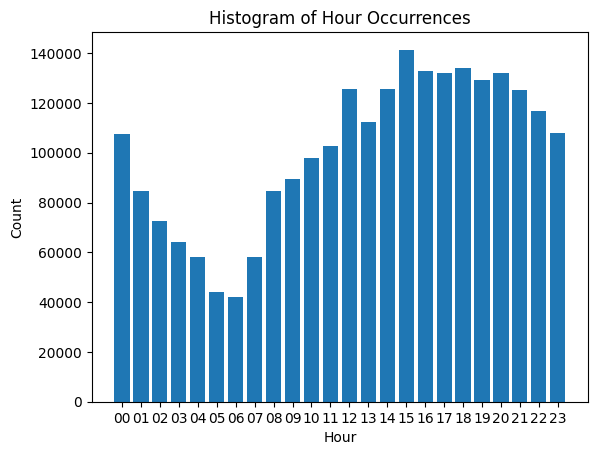

In [71]:
hours=men_suspect['CMPLNT_FR_TM'].str[:2]
hours=hours[~(hours=='(n')]
hours_dict=hours.value_counts(sort=False).to_dict()
print(hours_dict)
hours_sorted = dict(sorted(hours_dict.items(), key=lambda x: int(x[0])))

plt.bar(hours_sorted.keys(), hours_sorted.values())
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Histogram of Hour Occurrences")
plt.show()

# How did crime evolve through the years

In [81]:
df["year_begin"] = df['CMPLNT_FR_DT'].dt.year

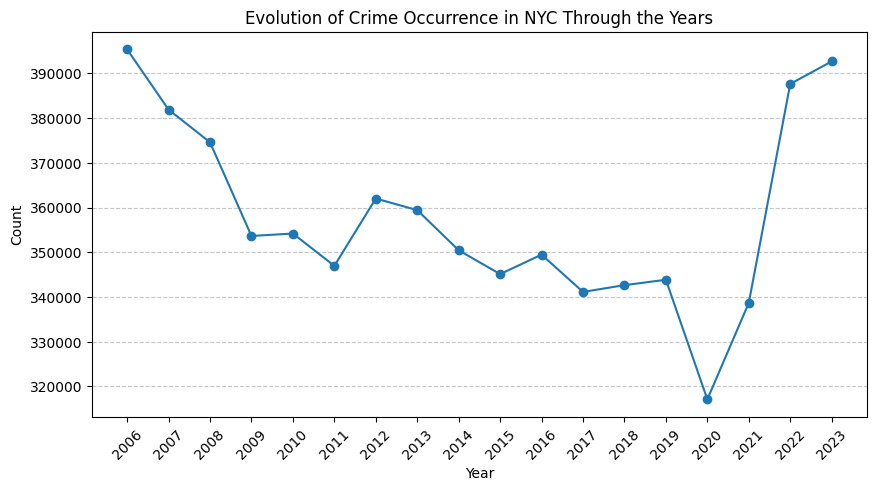

In [127]:
import matplotlib.pyplot as plt
df_gender['CMPLNT_FR_DT'] = pd.to_datetime(df_gender['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')
df_gender["year_begin"] = df_gender['CMPLNT_FR_DT'].dt.year  # Ensure year is extracted properly

df_year = df_gender.groupby('year_begin').agg(
    nb_crimes=('year_begin', 'size')
).reset_index()

df_year['year_begin'] = pd.to_numeric(df_year['year_begin'], errors='coerce').astype('Int64')
#Crop from 2006 not enough data
df_year = df_year.query("year_begin >= 2006")

plt.figure(figsize=(10, 5))

# Line plot with dots at each year
plt.plot(df_year["year_begin"], df_year["nb_crimes"], marker='o', linestyle='-')

# X-axis labels: show every year, rotate for readability
plt.xticks(df_year["year_begin"], rotation=45)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Evolution of Crime Occurrence in NYC Through the Years")

plt.grid(axis="y", linestyle="--", alpha=0.7)  # Optional grid for readability
plt.show()


Interesting result. A drop in 2020 during covid, then a huge increase.

In [118]:
#F=Female
#M=Male
#E=PSNY/People of the State of New York
#D=Business/Organization,
#L

df_E = df.query("VIC_SEX == 'E'")
print(df_E["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
DANGEROUS DRUGS                   450516
DANGEROUS WEAPONS                 161599
CRIMINAL MISCHIEF & RELATED OF    120437
INTOXICATED & IMPAIRED DRIVING     98051
OFFENSES AGAINST PUBLIC ADMINI     68632
FORGERY                            67740
MISCELLANEOUS PENAL LAW            56832
CRIMINAL TRESPASS                  49281
VEHICLE AND TRAFFIC LAWS           40928
OFFENSES INVOLVING FRAUD           19597
Name: count, dtype: int64


In [119]:
df_D = df.query("VIC_SEX == 'D'")
print(df_D["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
PETIT LARCENY                     615630
CRIMINAL MISCHIEF & RELATED OF    174540
GRAND LARCENY                     112179
BURGLARY                           96305
ROBBERY                            30825
GRAND LARCENY OF MOTOR VEHICLE     14840
CRIMINAL TRESPASS                  14480
POSSESSION OF STOLEN PROPERTY      12885
OFFENSES INVOLVING FRAUD           11443
FORGERY                            11205
Name: count, dtype: int64


In [121]:
df_L = df.query("VIC_SEX == 'L'")
print(df_L["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
FELONY ASSAULT                    2747
MISCELLANEOUS PENAL LAW           1129
OFFENSES AGAINST PUBLIC ADMINI     490
OFFENSES AGAINST THE PERSON        471
HARRASSMENT 2                      185
VEHICLE AND TRAFFIC LAWS           167
CRIMINAL MISCHIEF & RELATED OF      95
OFF. AGNST PUB ORD SENSBLTY &       88
DANGEROUS DRUGS                     85
DANGEROUS WEAPONS                   83
Name: count, dtype: int64


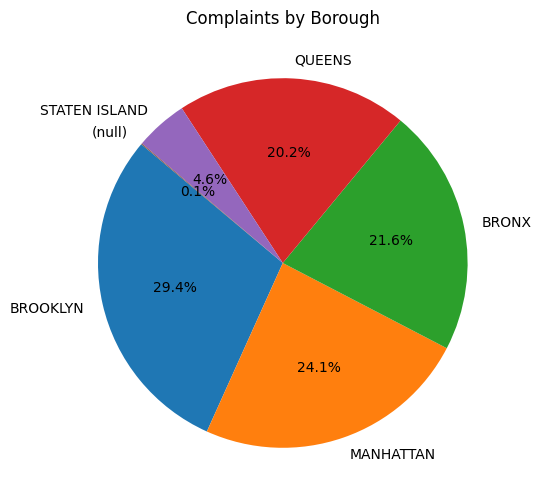

In [122]:
sizes = df['BORO_NM'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=sizes.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Complaints by Borough')
plt.show()

In [125]:
pd.set_option("display.max_rows",None)
df["OFNS_DESC"].value_counts()

OFNS_DESC
PETIT LARCENY                           1556946
HARRASSMENT 2                           1187346
ASSAULT 3 & RELATED OFFENSES             935330
CRIMINAL MISCHIEF & RELATED OF           876668
GRAND LARCENY                            783519
DANGEROUS DRUGS                          456550
OFF. AGNST PUB ORD SENSBLTY &            436929
FELONY ASSAULT                           363917
ROBBERY                                  314941
BURGLARY                                 297225
MISCELLANEOUS PENAL LAW                  233567
DANGEROUS WEAPONS                        181867
GRAND LARCENY OF MOTOR VEHICLE           174042
OFFENSES AGAINST PUBLIC ADMINI           156887
VEHICLE AND TRAFFIC LAWS                 136467
SEX CRIMES                               112267
INTOXICATED & IMPAIRED DRIVING           105206
CRIMINAL TRESPASS                         88742
FORGERY                                   88630
THEFT-FRAUD                               87739
FRAUDS                        